# Fitbit Exploration
For an explanation on the variables, take a look at the [data dictionary created by Fitabase](https://www.fitabase.com/media/1546/fitabasedatadictionary.pdf).

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Summary Notebook
In this notebook we take a look at the available data focusing on sleep parameters primarily.

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from joypy import joyplot

# Daily Data
We start by looking at the largest averaging window: daily recorded events.

In [3]:
daily_fitbit = pd.read_csv("../data/processed/fitbit-daily-ux_s20.csv",index_col=0,parse_dates=True)
daily_fitbit.head()

,calories,bmr,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,bmi,fat,weight,food_calories_logged,water_logged,beiwe
timestamp,,,,,,,,,,,,,,,
2020-05-13,2781.0,1876.0,9207,4.396294,1241,70,118,11,1097.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-14,3727.0,1876.0,15207,7.261114,614,263,134,23,2234.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-15,3909.0,1876.0,14556,8.028501,577,205,57,108,2381.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-16,3927.0,1876.0,18453,8.748670,760,176,24,151,2364.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-17,4180.0,1876.0,15425,7.973149,605,207,50,131,2652.0,23.754,0.0,180.0,0.0,0.0,hfttkth7


Adding a column for total active minutes which should give us a picture of whether or not their device was on the entire day.

In [4]:
daily_fitbit["activities_minutes"] = daily_fitbit[["sedentary_minutes","lightly_active_minutes",
                                                "fairly_active_minutes","very_active_minutes"]].sum(axis=1)
daily_fitbit["activities_percentage"] = daily_fitbit["activities_minutes"] / 1440 * 100
# checking to see if it makes sense - should be 1440
print("Max number of activity minutes:",np.max(daily_fitbit["activities_minutes"]))
# finding cutoffs for other variables
print("Max number of steps taken (for visualizing purposes):",np.max(daily_fitbit["steps"]))
print("Max number of calories burned (for visualizing purposes):",np.max(daily_fitbit["calories"]))

Max number of activity minutes: 1440
Max number of steps taken (for visualizing purposes): 37485
Max number of calories burned (for visualizing purposes): 6089.0


## Data Availability

### Heatmaps
Looking at heatmaps per participant to see logged data

In [5]:
def heatmaps_by_pt(df=daily_fitbit,var_list=['calories','steps','activities_minutes','activities_percentage'],limit_list = [[0,4000],[0,35000],[0,1440],[0,100]],save=False):
    """
    
    """
    fig, axes = plt.subplots(2,2,figsize=(24,14),sharey="row",sharex="col")
    for variable, limits, ax in zip(var_list, limit_list,axes.flat):
        heatmap_df = pd.DataFrame()
        for beiwe in daily_fitbit['beiwe'].unique():
            daily_fitbit_by_beacon = daily_fitbit[daily_fitbit['beiwe'] == beiwe]
            sdate = datetime(2020,6,1)
            edate = datetime(2020,10,1)
            daily_fitbit_by_beacon = daily_fitbit_by_beacon[sdate:edate]
            heatmap_df = pd.concat([heatmap_df,daily_fitbit_by_beacon[variable]],axis=1)
            heatmap_df.rename(columns={variable:beiwe}, inplace=True)

        df_to_plot = heatmap_df.T
        sns.heatmap(df_to_plot,vmin=limits[0],vmax=limits[1],cmap='Greens',ax=ax)
        # x-axis
        xlabels = ax.get_xticklabels()
        new_xlabels = []
        for label in xlabels:
            new_xlabels.append(label.get_text()[5:11])
        ax.set_xticklabels(new_xlabels)
        # y-axis
        ax.set_ylabel("Participant Beiwe ID")
        # remaining
        ax.set_title(variable)
    
    plt.subplots_adjust(hspace=0.1,wspace=0)
    if save:
        plt.savefig(f'../reports/figures/fitbit_summary/fitbit-{variable}-heatmap.pdf',bbox_inches="tight")
    plt.show()
    plt.close()

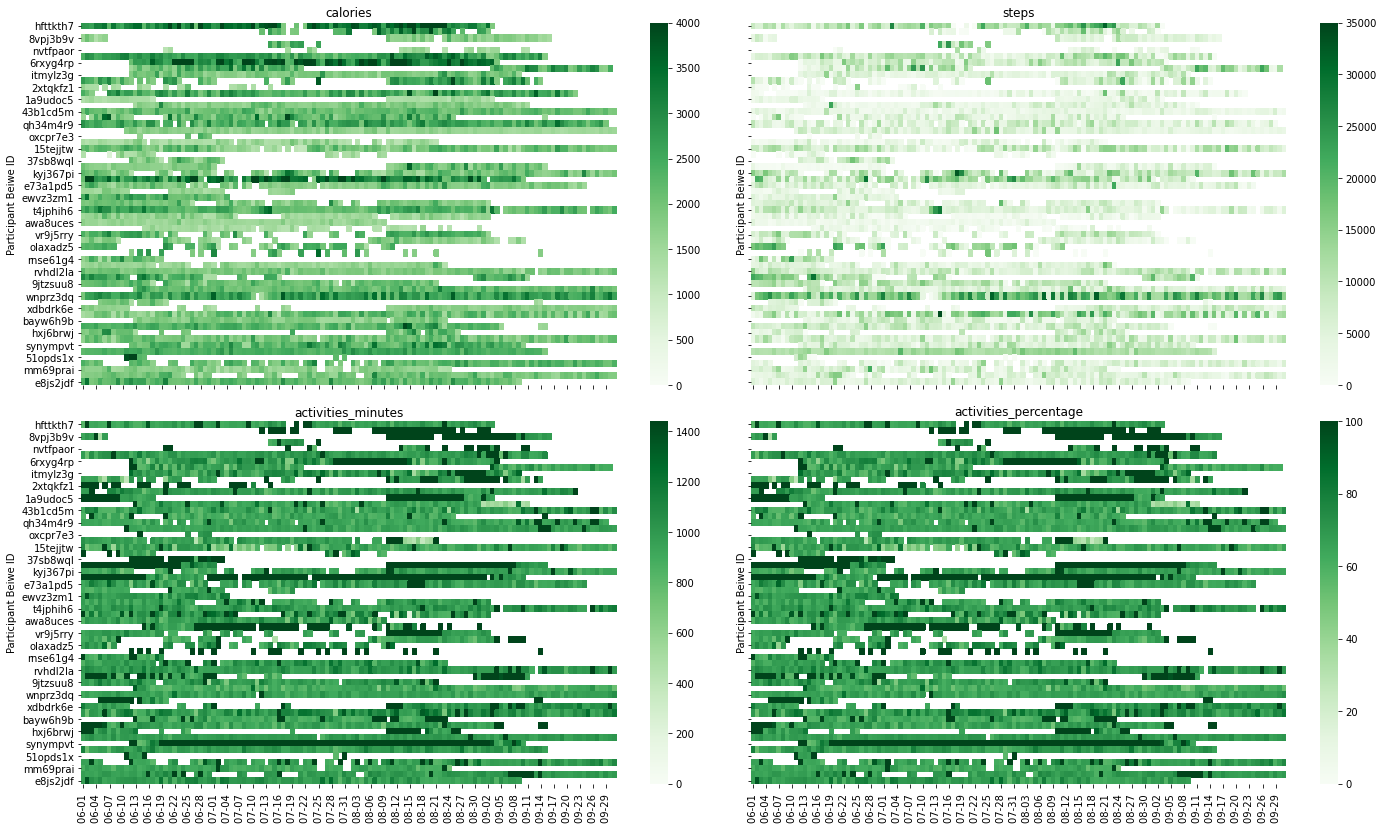

In [6]:
heatmaps_by_pt()

<div class="alert alert-block alert-warning">

The last figure gives the best insight into the available data from each participant. Cells with the lightest color correspond to 1440 minutes (1 day) meaning the Fitbit recorded data all day. 
    
</div>

<div class="alert alert-block alert-success">
We can improve upon the last figure, but converting the sum of minutes to a percentage and then plotting a heatmap of that!

More analysis on the completeness of Fitbit data is warranted. Here we look at the overall completeness of the participants' data collection and the number of days above a certain percentage of data collection.

### Number of Participants

Checking participants for each metric in ```daily_fitbit```

In [7]:
n_pts = len(daily_fitbit['beiwe'].unique())
print(f'Number of Overall Participants: {n_pts}')
pts_daily = np.sort(daily_fitbit['beiwe'].unique())
for col in daily_fitbit.columns:
    if col != 'beiwe':
        print(f'{col}:')
        temp_fitbit = daily_fitbit[[col,'beiwe']].dropna()
        n = len(temp_fitbit['beiwe'].unique())
        print(f'\tNumber of participants: {n}')

Number of Overall Participants: 59
calories:
	Number of participants: 59
bmr:
	Number of participants: 59
steps:
	Number of participants: 59
distance:
	Number of participants: 59
sedentary_minutes:
	Number of participants: 59
lightly_active_minutes:
	Number of participants: 59
fairly_active_minutes:
	Number of participants: 59
very_active_minutes:
	Number of participants: 59
calories_from_activities:
	Number of participants: 59
bmi:
	Number of participants: 59
fat:
	Number of participants: 59
weight:
	Number of participants: 59
food_calories_logged:
	Number of participants: 59
water_logged:
	Number of participants: 59
activities_minutes:
	Number of participants: 59
activities_percentage:
	Number of participants: 59


In [8]:
# ids
bid = []
for beiwe in daily_fitbit['beiwe'].unique():
    bid.append(beiwe)

### Number of Hours
We can use the activity minutes to get a sense of the number of minutes that were collected by the fitbit.

In [9]:
n_hours = np.sum(daily_fitbit['activities_minutes'] / 60)
print(f'Number of hours of data collected: {n_hours}')
print(f'Number of days of data collected: {n_hours / 24}')

Number of hours of data collected: 92271.86666666667
Number of days of data collected: 3844.661111111111


### Average completeness when wearing the Fitbit

And with that, now we plot with number of days and percetnage

In [10]:
def get_completness_cutoffs():
    fig, ax = plt.subplots(figsize=(8,4))
    for i in range(len(cutoffs.columns)):
        ax.scatter(i,cutoffs.sum().iloc[i],color='cornflowerblue',zorder=4,s=80)
        #ax.text(i,cutoffs.sum().iloc[i],f'{cutoffs.sum().iloc[i]}',ha='left',va='top',zorder=10)

    ax.set_xlim([-0.5,4.5])
    ax.set_xticks(np.arange(0,5,1))
    ax.set_xticklabels(['Total','>50','>75','>85','>95'])
    ax.set_ylabel('Number of Days')

    ax2 = ax.twinx()
    for i in range(len(cutoffs.columns)):
        ax2.scatter(i,cutoffs.sum().iloc[i]/cutoffs.sum().iloc[0]*100,color='cornflowerblue',zorder=2,alpha=0,s=125)

    ax2.set_ylabel('Percentage')
    ax.grid('both',zorder=1)

    #plt.savefig(f'../reports/utx000_initial_update/figures/fitbit-fitbit-daily-completeness-combined.pdf')
    #plt.savefig(f'../reports/BuildSys2020/fitbit-fitbit-daily-completeness-combined.pdf')
    plt.show()
    plt.close()

## Sleep Data
Sleep data is a subset of the daily data and we can check to see how many nights of data we have available at least from the current dataset.


In [273]:
daily_sleep = pd.read_csv("../data/processed/fitbit-sleep_daily-ux_s20.csv",parse_dates=["date","start_time","end_time"],infer_datetime_format=True)
# converting duration to something that makes more sense...
daily_sleep['hours_asleep'] = daily_sleep['duration_ms'] / 3600000
daily_sleep.sort_values(["beiwe","start_time"]).head()

,duration_ms,efficiency,end_time,main_sleep,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_sleep,start_time,time_in_bed,date,beiwe,redcap,beacon,sol,wol,hours_asleep
1197,38400000,88.593750,2020-05-01 12:12:30,True,0,567,73,0,2020-05-01 01:32:30,640,2020-05-01,15tejjtw,45.0,NaN,0.5,0.0,10.666667
1198,39060000,85.560676,2020-05-02 13:13:00,True,0,557,94,0,2020-05-02 02:21:30,651,2020-05-02,15tejjtw,45.0,NaN,16.5,0.0,10.850000
1199,21660000,83.379501,2020-05-03 08:01:00,True,1,301,60,0,2020-05-03 01:59:30,361,2020-05-03,15tejjtw,45.0,NaN,0.5,5.0,6.016667
1200,36480000,84.703947,2020-05-04 14:13:30,True,0,515,93,0,2020-05-04 04:05:00,608,2020-05-04,15tejjtw,45.0,NaN,0.5,4.0,10.133333
1201,30420000,85.404339,2020-05-06 10:24:00,True,0,433,74,0,2020-05-06 01:56:30,507,2020-05-06,15tejjtw,45.0,NaN,0.5,0.0,8.450000


The [data dictionary](https://www.fitabase.com/media/1546/fitabasedatadictionary.pdf) for these variables can be quite enlightening as many of these variables are useless.

### Summary of Data Collected
We start with a look at the data that have been collected.

In [274]:
n_sleep = len(daily_sleep["beiwe"].unique())
print("Number of participants with sleep data:",n_sleep)
print()
daily_sleep_by_time = daily_sleep.sort_values("start_time")
print("First submmission:",daily_sleep_by_time.iloc[0]["start_time"])
print("Last submmission:",daily_sleep_by_time.iloc[-1,:]["start_time"])

Number of participants with sleep data: 56

First submmission: 2020-04-30 22:29:30
Last submmission: 2021-02-22 02:33:30


### Scatter of Number of Nights
Here we look at how many nights of data each participant recorded

In [275]:
def get_number_nights_by_pt(df=daily_sleep, by_id="beiwe",start_date=datetime(2020,6,1), end_date=datetime(2020,10,1), save=False):
    """
    
    """
    # Number of nights recorded
    pids = []
    sleep_recorded = []
    # Looping through beiwe participants
    for pt in df[by_id].unique():
        sleep_by_pt = df[df[by_id] == pt]
        sleep_by_pt.set_index("date",inplace=True)
        sleep_by_pt = sleep_by_pt[start_date:end_date]
        if len(sleep_by_pt) > 0:
            pids.append(pt)
            sleep_recorded.append(len(sleep_by_pt))

    fig, ax = plt.subplots(figsize=(16,5))
    df_to_plot = pd.DataFrame(data={"id":pids,"nights":sleep_recorded})
    df_to_plot["id"] = df_to_plot["id"].astype(int).astype(str)
    df_to_plot.sort_values(["nights"],ascending=False,inplace=True)
    # scattering number of nights recorded eper participant
    ax.scatter(df_to_plot["id"],df_to_plot["nights"],s=100,color="black", zorder=10)
    # average line
    ax.axhline(np.mean(df_to_plot["nights"]),color="black",linewidth=2,linestyle="dashed")
    # x-axis
    ax.set_xlabel("Participant ID",fontsize=15)
    plt.setp(ax.get_xticklabels(), ha="center", rotation=0, fontsize=10)
    # y-axis
    ax.set_ylabel("Number of Nights Recorded",fontsize=15)
    plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=13)
    ax.set_yticks(np.arange(0,130,10))
    # remaining
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    
    if save:
        plt.savefig("../reports/figures/fitbit_summary/fitbit-number_nights_recorded-ux_s20.png",bbox_inches="tight")
        plt.savefig('../../papers/5eea5276044b790001ee5687/figures/fitbit-number_nights_recorded-ux_s20.pdf',bbox_inches="tight")
    plt.show()
    plt.close()
    
    return df_to_plot

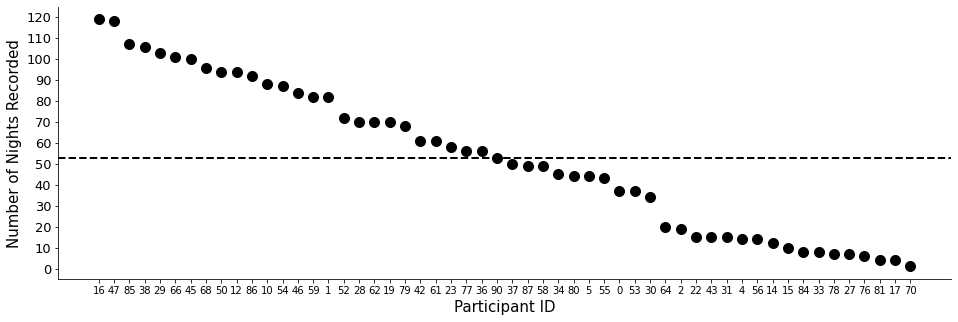

In [276]:
temp = get_number_nights_by_pt(by_id="redcap",save=True)

In [277]:
days = (datetime(2020,10,1) - datetime(2020,6,1)).days
print(f'Maximum number of days: {days}')
print(f"Maximum number of nights recorded:", np.max(temp["nights"]))
print(f"Average number of nights recorded:", np.mean(temp["nights"]))
print(f"Minimum number of nights recorded:", np.min(temp["nights"]))
print(f'Number of total nights recorded: {np.sum(temp["nights"])}')
print(f"Number of participants: {len(temp['id'].unique())}")

Maximum number of days: 122
Maximum number of nights recorded: 119
Average number of nights recorded: 52.94444444444444
Minimum number of nights recorded: 1
Number of total nights recorded: 2859
Number of participants: 54


### Getting Sleep Metric DataFrame
We need to get a dataframe that summarizes the sleep metrics we want to include

In [278]:
fitbit_sleep_summary = pd.read_csv("../data/processed/beiwe_fitbit-sleep_summary-ux_s20.csv",parse_dates=["date","start_date","end_date","start_time","end_time"],infer_datetime_format=True)
fitbit_sleep_summary.sort_values(["beiwe","start_time"]).head()

,date,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe,efficiency,end_time,start_time,redcap,beacon,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,waso,sol_fb,wol_fb,tst_ema,sol_ema,naw_ema,restful_ema
0,2020-05-14,2020-05-14,2020-05-14,3,73,45,331,8,122,47,107,15tejjtw,83.096367,2020-05-14 11:39:30,2020-05-14 01:06:00,45.0,NaN,48,404,0.301980,10.550000,0.192733,0.638231,84.5,13.0,9.5,9.0,30.0,5.0,2.0
1,2020-05-16,2020-05-16,2020-05-16,2,65,31,282,6,49,35,65,15tejjtw,85.900217,2020-05-16 10:00:30,2020-05-16 02:19:00,45.0,NaN,33,347,0.141210,7.683333,0.106291,0.752711,57.5,4.0,3.5,9.0,15.0,2.0,2.0
2,2020-05-17,2020-05-17,2020-05-17,4,123,31,273,15,135,35,70,15tejjtw,88.352745,2020-05-17 10:28:00,2020-05-17 00:27:00,45.0,NaN,35,396,0.340909,10.016667,0.224626,0.658902,53.0,13.0,4.0,9.0,30.0,1.0,2.0
3,2020-05-18,2020-05-18,2020-05-18,5,80,33,299,5,99,28,84,15tejjtw,85.053381,2020-05-18 10:59:30,2020-05-18 01:37:00,45.0,NaN,38,379,0.261214,9.366667,0.176157,0.674377,71.0,13.0,0.0,9.0,25.0,2.0,1.0
4,2020-05-22,2020-05-21,2020-05-22,6,102,30,265,17,132,35,69,15tejjtw,87.852113,2020-05-22 09:27:30,2020-05-21 23:59:30,45.0,NaN,36,367,0.359673,9.466667,0.232394,0.646127,56.0,0.0,13.0,9.0,20.0,2.0,2.0


Getting important columns i.e. metrics to consider and IDs

In [279]:
fitbit_sleep_metrics = fitbit_sleep_summary[["date","beiwe","redcap","tst_fb","efficiency","rem2nrem","waso"]]
fitbit_sleep_metrics.columns = ["date","beiwe","redcap","tst","se","rem_to_nrem","waso"]
fitbit_sleep_metrics.sort_values("waso",ascending=False).head()

,date,beiwe,redcap,tst,se,rem_to_nrem,waso
185,2020-07-15,7dhu3pn7,64.0,11.450000,78.893741,0.223476,144.5
57,2020-06-28,43b1cd5m,66.0,10.883333,77.947933,0.096983,137.0
11,2020-06-08,15tejjtw,45.0,14.650000,85.210466,0.387037,130.0
61,2020-07-29,43b1cd5m,66.0,8.666667,73.461538,0.088319,122.0
644,2020-05-27,qh34m4r9,68.0,11.783333,80.905233,0.227468,121.0


### Histograms
Now we take a look at the typical values recorded for various components of sleep.

In [280]:
def plot_sleep_histogram(df,max_freq=400,save=False):
    """
    
    """
    questions = ['tst','se','waso','rem_to_nrem']
    xlabels = ["TST (hours)","SE (%)","WASO (minutes)","REM:nREM"]
    bin_list = [np.arange(0,15,1),
               np.arange(70,102.5,2.5),
               np.arange(0,160,10),
               np.arange(0,0.7,0.05)]
    titles = ["a","b","c","d"]

    fig, axes = plt.subplots(1,4,figsize=(24,4),sharey="row")#,gridspec_kw={'width_ratios': [5,5,5,4]})
    for question, bins, ax, xlabel, title in zip(questions, bin_list, axes.flat, xlabels, titles):
        n,bins,patches = ax.hist(df[question],bins=bins,color="black", rwidth=0.9,align='mid')
        
        # x-axis
        ax.set_xlabel(xlabel,fontsize=15)
        plt.setp(ax.get_xticklabels(), ha="center", rotation=0, fontsize=12)
        # y-axis
        ax.set_ylim([0,max_freq])
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=12)

        #ax.set_title(f'Median Response for {question}: {np.nanmedian(morning[question])}')

        #label_hist(n, bins, ax)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        ax.set_title(title,fontsize=16,pad=0)
        
    axes[0].set_ylabel('Frequency',fontsize=16)
    #axes[1,0].set_ylabel('Frequency',fontsize=15)
    plt.subplots_adjust(wspace=0.05)
    if save:
        plt.savefig("../../papers/5eea5276044b790001ee5687/figures/fitbit-sleep_metrics-histogram-ux_s20.pdf",bbox_inches="tight")
        plt.savefig("../reports/figures/fitbit_summary/fitbit-sleep_metrics-histogram-ux_s20.pdf",bbox_inches="tight")
    plt.show()
    plt.close()

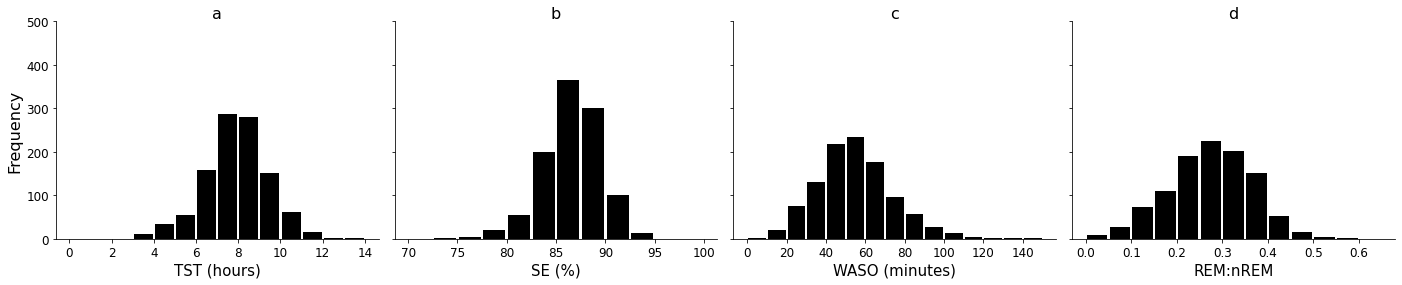

In [281]:
plot_sleep_histogram(fitbit_sleep_metrics,max_freq=500,save=True)

#### TST

In [21]:
p_7to9 = len(fitbit_sleep_metrics[(fitbit_sleep_metrics['tst'] >= 7) & (fitbit_sleep_metrics['tst'] <= 9)])/len(fitbit_sleep_metrics['tst'])
print('Number of nights between 7 and 9 hours of sleep:\t', p_7to9*100)
p_7toInf = len(fitbit_sleep_metrics[(fitbit_sleep_metrics['tst'] >= 7)])/len(fitbit_sleep_metrics['tst'])
print('Number of nights greater than 7 hours of sleep:\t\t', p_7toInf*100)

Number of nights between 7 and 9 hours of sleep:	 53.77358490566038
Number of nights greater than 7 hours of sleep:		 75.37735849056604


#### SE

In [186]:
print("Minimum Sleep Efficiency:",min(fitbit_sleep_metrics['se']))
print("Maximum Sleep Efficiency:",max(fitbit_sleep_metrics['se']))

Minimum Sleep Efficiency: 73.46153846153847
Maximum Sleep Efficiency: 94.16666666666669


In [185]:
len(fitbit_sleep_metrics[fitbit_sleep_metrics['se'] < 75])

2

In [188]:
p_gt_65 = len(fitbit_sleep_metrics[(fitbit_sleep_metrics['se'] >= 65)])/len(fitbit_sleep_metrics['se'])
print('Number of nights we se greater than 65%:\t\t', p_gt_65*100)
p_gt_75 = len(fitbit_sleep_metrics[(fitbit_sleep_metrics['se'] >= 75)])/len(fitbit_sleep_metrics['se'])
print('Number of nights we se greater than 75%:\t\t', p_gt_75*100)
p_gt_85 = len(fitbit_sleep_metrics[(fitbit_sleep_metrics['se'] >= 85)])/len(fitbit_sleep_metrics['se'])
print('Number of nights we se greater than 85%:\t\t', p_gt_85*100)
p_gt_90 = len(fitbit_sleep_metrics[(fitbit_sleep_metrics['se'] >= 90)])/len(fitbit_sleep_metrics['se'])
print('Number of nights we se greater than 90%:\t\t', p_gt_90*100)
p_gt_95 = len(fitbit_sleep_metrics[(fitbit_sleep_metrics['se'] >= 95)])/len(fitbit_sleep_metrics['se'])
print('Number of nights we se greater than 95%:\t\t', p_gt_95*100)

Number of nights we se greater than 65%:		 100.0
Number of nights we se greater than 75%:		 99.81132075471699
Number of nights we se greater than 85%:		 73.39622641509433
Number of nights we se greater than 90%:		 10.660377358490566
Number of nights we se greater than 95%:		 0.0


#### WASO

In [282]:
p_lt_20 = len(fitbit_sleep_metrics[(fitbit_sleep_metrics['waso'] <= 20)])/len(fitbit_sleep_metrics['waso'])
print('Percent of nights with WASO less than 20:\t\t', p_lt_20*100)
p_gt_40 = len(fitbit_sleep_metrics[(fitbit_sleep_metrics['waso'] > 40)])/len(fitbit_sleep_metrics['waso'])
print('Percent of nights with WASO greater than 40:\t\t', p_gt_40*100)

Percent of nights with WASO less than 20:		 2.358490566037736
Percent of nights with WASO greater than 40:		 78.01886792452831


#### REM:nREM

In [28]:
p_25to33 = len(fitbit_sleep_metrics[(fitbit_sleep_metrics['rem_to_nrem'] >= 0.25) & (fitbit_sleep_metrics['rem_to_nrem'] < 0.34)])/len(fitbit_sleep_metrics['rem_to_nrem'])
print('Percentrage of nights between 20 and 33 REM:nREM:\t', p_25to33*100)

Percentrage of nights between 20 and 33 REM:nREM:	 36.79245283018868


#### Minute Recordings
These histograms summarize some of the (what look like) important data that are on similar minute-scales.

Working for minutes summary
	Plotting
Working for minutes summary
	Plotting
Working for minutes summary
	Plotting


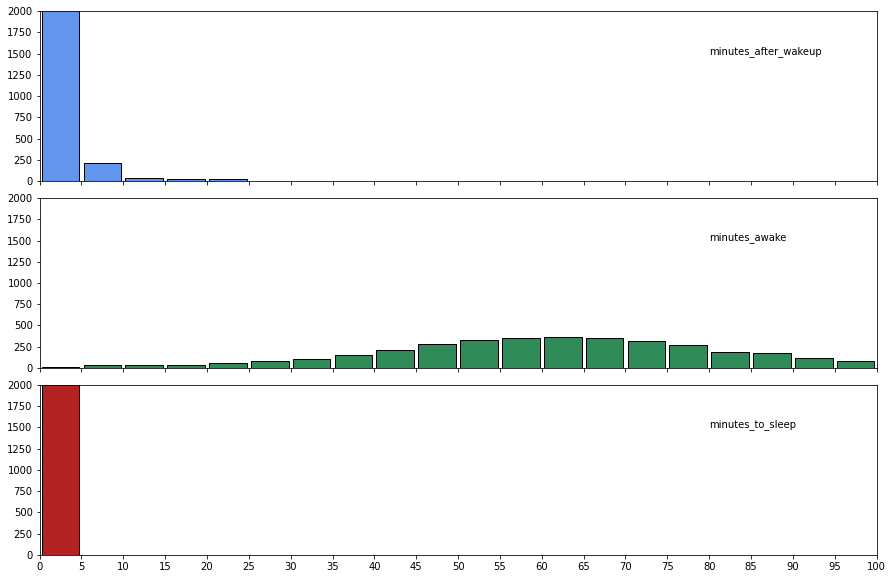

In [29]:
var_list = ['minutes_after_wakeup','minutes_awake','minutes_to_sleep']
colors= ["cornflowerblue","seagreen","firebrick"]
fig, axes = plt.subplots(3,1,figsize=(15,10),sharex=True)
bins = np.arange(0,105,5)
for i in range(len(var_list)):
    print(f'Working for minutes summary')
    print(f'\tPlotting')
        
    axes[i].hist(daily_sleep[var_list[i]],color=colors[i],edgecolor="black",rwidth=0.9,bins=bins)
    axes[i].set_xticks(bins)
    axes[i].set_xlim([bins[0],bins[-1]])
    axes[i].set_ylim([0,2000])
    
    axes[i].text(80,1500,var_list[i])
    
plt.subplots_adjust(hspace=0.1)
plt.show()
plt.close()

<div class="alert alert-block alert-info">
These variables provide us with some potential links to explore:
    <ul>
        <li>TST and IAQ</li>
        <li>Efficiency and IAQ</li>
        <li>Minutes Awake and IAQ</li>
        <li>Awake Count and IAQ</li>
        <li>Awakenings Count and IAQ</li>
        <li>Restless Count and IAQ (might be similar to previous point)</li>  
    </ul>
</div>

### Heatmaps
Heatmaps will show gaps and give us a decent idea of the values measured.

In [30]:
# Getting extreme values
print(np.min(daily_sleep['hours_asleep']))
print(np.max(daily_sleep['hours_asleep']))
print(np.min(daily_sleep['efficiency']))
print(np.max(daily_sleep['efficiency']))

1.05
17.683333333333334
27
100


Working for hours_asleep
	Data collected
	Plotting


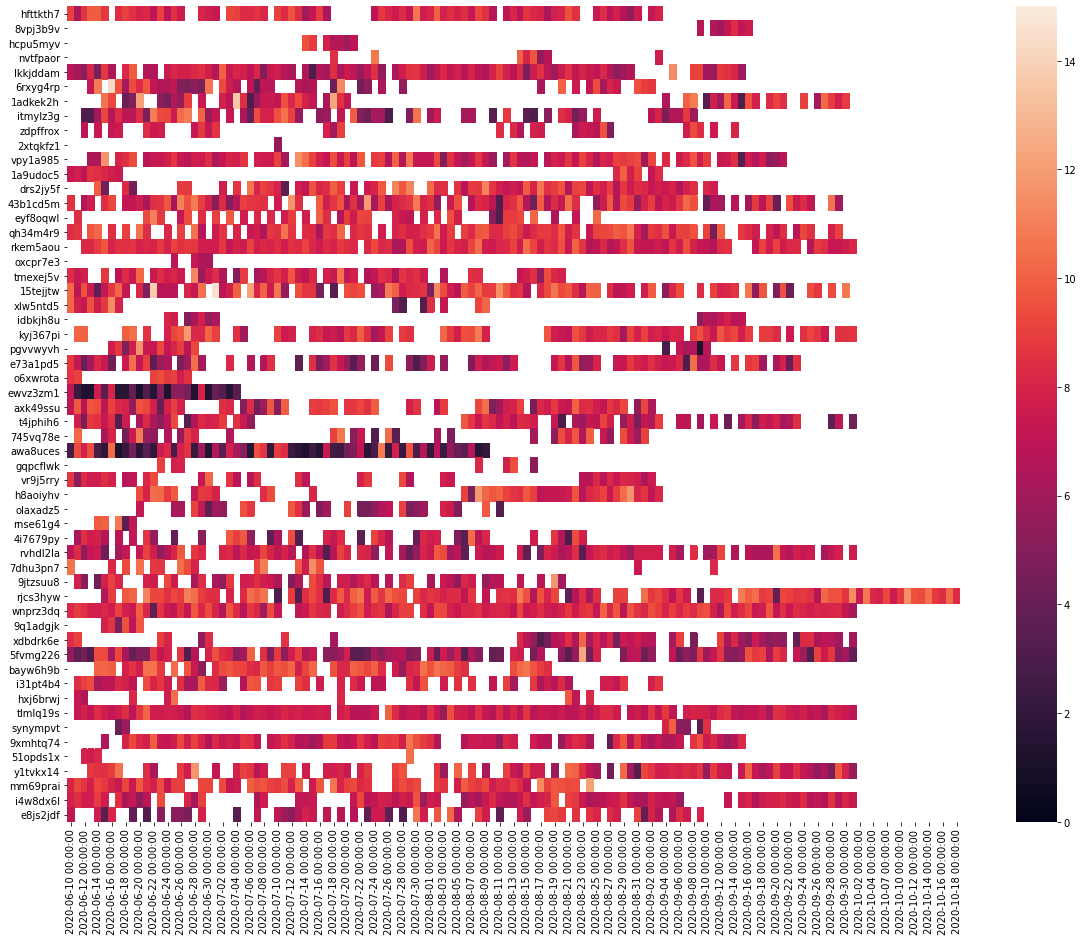

Working for efficiency
	Data collected
	Plotting


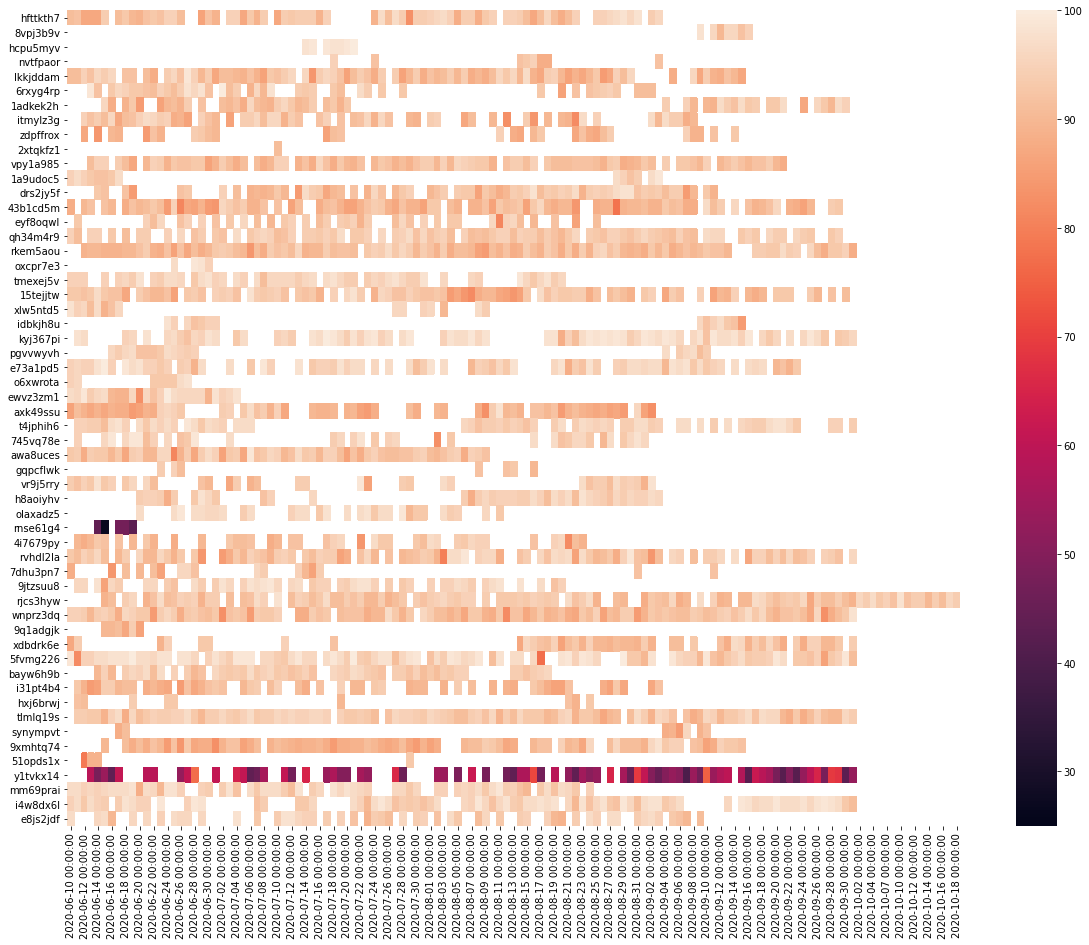

In [31]:
var_list = ['hours_asleep','efficiency',]
limit_list = [[0,15],[25,100]]
for variable, limits in zip(var_list, limit_list):
    print(f'Working for {variable}')
    heatmap_df = pd.DataFrame()
    for beiwe in daily_sleep['beiwe'].unique():
        daily_fitbit_by_beacon = daily_sleep[daily_sleep['beiwe'] == beiwe]
        daily_fitbit_by_beacon.set_index("date",inplace=True)
        sdate = datetime(2020,6,10)
        edate = datetime(2020,10,20)
        daily_fitbit_by_beacon = daily_fitbit_by_beacon[sdate:edate]
        heatmap_df = pd.concat([heatmap_df,daily_fitbit_by_beacon[variable]],axis=1)
        heatmap_df.rename(columns={variable:beiwe}, inplace=True)

    print(f'\tData collected')
    fig, ax = plt.subplots(figsize=(20,15))
    df_to_plot = heatmap_df.T
    print(f'\tPlotting')
    sns.heatmap(df_to_plot,vmin=limits[0],vmax=limits[1])
        
    #x_labels = []
    #for d in pd.date_range(sdate,edate-timedelta(days=1),freq='d'):
    #    x_labels.append(d.strftime('%m-%d'))
        
    #ax.set_xticklabels(x_labels)
    
    plt.show()
    plt.close()

### Fitbit Sleep Data for Beacon-Holders at Home
These next few sections consider only the sleep data from participants who also received a BEVO Beacon and were at their residences.

Getting beacon data restricted beacon data just to determine the nights to use.

In [32]:
# partially filtered beacon data with sleep start times
partial_beacon_df = pd.read_csv('../data/processed/beacon-fb_and_gps_filtered-ux_s20.csv',
                        index_col=0,parse_dates=[0,-2,-1],infer_datetime_format=True)

partial_sleep_df = pd.DataFrame() # dataframe to hold the relevant sleep data
# looping through partially filtered data and merging dataframes on common start times
for pt in partial_beacon_df['beiwe'].unique():
    daily_sleep_pt = daily_sleep[daily_sleep['beiwe'] == pt]
    partial_beacon_pt = partial_beacon_df[partial_beacon_df['beiwe'] == pt]
    if len(partial_beacon_pt) > 0:
        partial_beacon_pt_summary = partial_beacon_pt.groupby('start_time').mean()
        partial_sleep_df = partial_sleep_df.append(pd.merge(left=partial_beacon_pt_summary,right=daily_sleep_pt,left_on='start_time',right_on='start_time',how='inner'))
        
partial_sleep_df.drop(["lat","long","altitude","accuracy",
                       "tvoc","lux","no2","co","co2","pm1_mass","pm2p5_mass","pm10_mass","pm1_number","pm2p5_number","pm10_number","temperature_c","rh"],
                      axis=1,inplace=True)
    

The length of this dataframe should correspond to 318 nights.

In [33]:
print('Number of nights:', len(partial_sleep_df))

Number of nights: 332


In [34]:
def plot_stacked_hist(df,var,limits,width=1,cmap='coolwarm',by_var='beiwe',save=False,save_dir='../reports/figures/',study_suffix="ux_s20"):
    '''
    Plots a stacked histogram with each color representing a unique individual.
    
    Inputs:
    - df: dataframe of the data
    - var: string specifying the column in the dataframe to plot
    - limits: tuple representing the lower and upper bound on the x-axis
    - width: integer/float for the width of each bin
    - by_var: string specifying the column to color the stacks by
    - save: boolean to save or not
    - save_dr: string representing the location to save the figure if save is True
    
    Returns the axes with the histogram
    '''
    list_to_plot = []
    for pt in df[by_var].unique():
        temp_df = df[df[by_var] == pt]
        list_to_plot.append(temp_df[var].to_list())
    
    colors = cm.get_cmap(cmap, len(list_to_plot))
    fig, ax = plt.subplots(figsize=(8,4))
    n, bins, _ = ax.hist(list_to_plot,bins=np.arange(limits[0],limits[1]+width,width),stacked=True,rwidth=0.9,
            color=colors(np.linspace(0, 1, len(list_to_plot))),edgecolor='black')

    if save == True:
        plt.savefig(f'{save_dir}/{var}-stacked_hist-{study_suffix}.pdf')
        
    return ax
    

#### TST

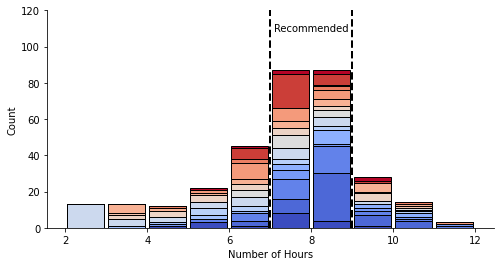

In [35]:
ax = plot_stacked_hist(partial_sleep_df,'hours_asleep',[2,12])
ax.set_ylabel('Count')
ax.set_ylim([0,120])
ax.set_xlabel('Number of Hours')
for loc in ['right','top']:
    ax.spines[loc].set_visible(False)
    
ax.axvline(7,color='black',linestyle='dashed',linewidth=2)
ax.axvline(9,color='black',linestyle='dashed',linewidth=2)
ax.text(8,110,"Recommended",ha='center',va='center')

#plt.savefig('../reports/figures/fitbit_sleep_duration-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

In [36]:
p_7to9 = len(partial_sleep_df[(partial_sleep_df['hours_asleep'] >= 7) & (partial_sleep_df['hours_asleep'] <= 9)])/len(partial_sleep_df['hours_asleep'])
print('Number of nights between 7 and 9 hours of sleep:\t', p_7to9*100)

p_7toInf = len(partial_sleep_df[(partial_sleep_df['hours_asleep'] >= 7)])/len(partial_sleep_df['hours_asleep'])
print('Number of nights greater than 7 hours of sleep:\t\t', p_7toInf*100)

p_gt_9 = len(partial_sleep_df[(partial_sleep_df['hours_asleep'] > 9)])/len(partial_sleep_df['hours_asleep'])
print('Number of nights greater than 9 hours of sleep:\t\t', p_gt_9*100)

p_lt_6 = len(partial_sleep_df[(partial_sleep_df['hours_asleep'] < 7)])/len(partial_sleep_df['hours_asleep'])
print('Number of nights less than 7 hours of sleep:\t\t', p_lt_6*100)


Number of nights between 7 and 9 hours of sleep:	 53.01204819277109
Number of nights greater than 7 hours of sleep:		 65.96385542168674
Number of nights greater than 9 hours of sleep:		 12.951807228915662
Number of nights less than 7 hours of sleep:		 34.036144578313255


#### Sleep Efficiency

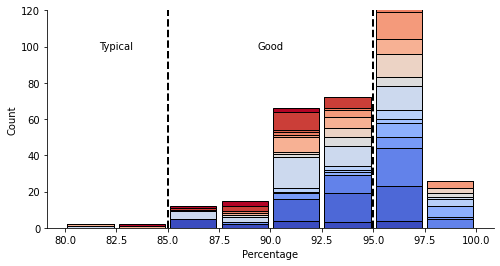

In [37]:
ax = plot_stacked_hist(partial_sleep_df,'efficiency',[80,100],width=2.5)
ax.set_ylabel('Count')
ax.set_ylim([0,120])
ax.set_xlabel('Percentage')
for loc in ['right','top']:
    ax.spines[loc].set_visible(False)
    
ax.axvline(85,color='black',linestyle='dashed',linewidth=2)
ax.axvline(95,color='black',linestyle='dashed',linewidth=2)
ax.text(82.5,100,"Typical",ha='center',va='center')
ax.text(90,100,"Good",ha='center',va='center')
    
#plt.savefig('../reports/figures/fitbit_sleep_efficiency-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

In [38]:
lowest_se = np.nanmin(partial_sleep_df[partial_sleep_df['efficiency']>70]['efficiency'].to_list())
print('The lowest measured SE:',lowest_se)

The lowest measured SE: 81


#### WASO
We need the breakdown of stages for each night since we have to exclude the wake periods at the beginning and end of the sleep episode.

In [39]:
sleep_stages = pd.read_csv("../data/processed/fitbit-sleep_stages-ux_s20.csv",index_col="start_date",parse_dates=["start_date","end_date","time"])
sleep_stages.head()

,end_date,time,stage,time_at_stage,beiwe,value
start_date,,,,,,
2020-05-14,2020-05-14,2020-05-14 00:27:00,wake,510,hfttkth7,0
2020-05-14,2020-05-14,2020-05-14 00:35:30,light,420,hfttkth7,1
2020-05-14,2020-05-14,2020-05-14 00:42:30,deep,1590,hfttkth7,2
2020-05-14,2020-05-14,2020-05-14 01:09:00,light,1290,hfttkth7,1
2020-05-14,2020-05-14,2020-05-14 01:30:30,rem,840,hfttkth7,3


Now we create a function that determines WASO for each night and each participant.

In [40]:
def get_waso_and_sol(df, by_var='beiwe'):
    '''
    Determines the minutes awake after sleep onset (waso) and sleep onset latency (sol)
    
    Inputs:
    - df: dataframe with sleep data
    - by_var: string specifying what id to parse by
    
    Returns dataframe with night, waso, sol, and by_var id
    '''
    waso_dict={'night':[],'waso':[],'sol':[],'beiwe':[]}
    for pt in df[by_var].unique():
        df_pt = df[df[by_var] == pt]
        for night in df_pt['end_date'].unique():
            # dropping first and last entries regardless of what they are
            df_pt_night = df_pt[df_pt['end_date'] == night]
            # df of wake periods
            df_pt_night_limited = df_pt_night[1:-1]
            df_pt_wake = df_pt_night_limited[df_pt_night_limited['stage'] == 'wake']
            # getting sol
            sol = 0
            if df_pt_night['stage'].iloc[0] == 'wake':
                sol = df_pt_night['time_at_stage'].iloc[0]/60
                
            waso_dict['night'].append(night)
            waso_dict['waso'].append(df_pt_wake['time_at_stage'].sum()/60)
            waso_dict['sol'].append(sol)
            waso_dict['beiwe'].append(pt)
            
    return pd.DataFrame(waso_dict)

Now we get that WASO information and cross reference the nights with the partially filtered data so that we are only including the 318 nights for analysis.

In [41]:
sleep_metric_df = get_waso_and_sol(sleep_stages)
partial_sleep_metric_df = pd.DataFrame() # dataframe to hold the relevant sleep data
# looping through partially filtered data and merging dataframes on common start times
for pt in partial_sleep_df['beiwe'].unique():
    partial_sleep_pt = partial_sleep_df[partial_sleep_df['beiwe'] == pt]
    sm_pt = sleep_metric_df[sleep_metric_df['beiwe'] == pt]
    sm_pt.drop(['beiwe'],axis=1,inplace=True)
    
    partial_sleep_metric_df = partial_sleep_metric_df.append(pd.merge(left=partial_sleep_pt,right=sm_pt,left_on="date",right_on='night',how='inner'))

print('Number of nights of WASO measurements:', len(partial_sleep_metric_df))

Number of nights of WASO measurements: 282


Now that we filtered the dataset, we plot.

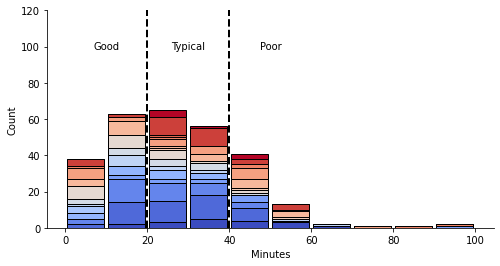

In [42]:
ax = plot_stacked_hist(partial_sleep_metric_df,'waso',[0,100],width=10)
ax.set_ylabel('Count')
ax.set_ylim([0,120])
ax.set_xlabel('Minutes')
for loc in ['right','top']:
    ax.spines[loc].set_visible(False)
    
ax.axvline(20,color='black',linestyle='dashed',linewidth=2)
ax.axvline(40,color='black',linestyle='dashed',linewidth=2)
ax.text(10,100,"Good",ha='center',va='center')
ax.text(30,100,"Typical",ha='center',va='center')
ax.text(50,100,"Poor",ha='center',va='center')
    
#plt.savefig('../reports/figures/fitbit_sleep_waso-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

In [43]:
for cutoff in [20,40]:
    waso_lt_cutoff = partial_sleep_metric_df[partial_sleep_metric_df['waso'] < cutoff]
    print(f'Percentage of nights with WASO less than {cutoff} minutes:', round(len(waso_lt_cutoff)/len(partial_sleep_metric_df),3)*100)

Percentage of nights with WASO less than 20 minutes: 35.8
Percentage of nights with WASO less than 40 minutes: 78.7


#### SOL
When we determined WASO, we also got SOL so all we need to do is plot with the same dataframe but a different value column.

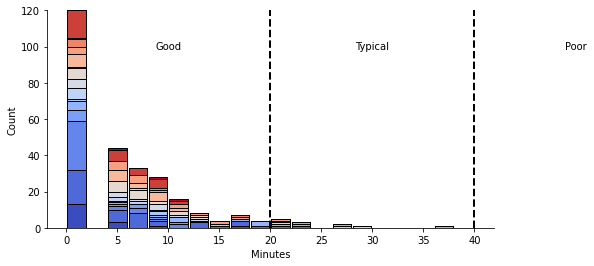

In [44]:
ax = plot_stacked_hist(partial_sleep_metric_df,'sol',[0,40],width=2)
ax.set_ylabel('Count')
ax.set_ylim([0,120])
ax.set_xlabel('Minutes')
for loc in ['right','top']:
    ax.spines[loc].set_visible(False)
    
ax.axvline(20,color='black',linestyle='dashed',linewidth=2)
ax.axvline(40,color='black',linestyle='dashed',linewidth=2)
ax.text(10,100,"Good",ha='center',va='center')
ax.text(30,100,"Typical",ha='center',va='center')
ax.text(50,100,"Poor",ha='center',va='center')
    
plt.savefig('../reports/figures/fitbit_sleep_sol-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

Upon inspection, there appears to be quite a few of nights with SOL less than 2 minutes which makes me not trust this metric.

In [45]:
sol_lt_2 = len(partial_sleep_metric_df[partial_sleep_metric_df['sol'] < 2])
print('Number of nights with SOL less than 2 minutes:', sol_lt_2)

Number of nights with SOL less than 2 minutes: 125


#### REM:non-REM
To get this ratio, we have to use the sleep minute data and cross-reference it with the partially filtered sleep data from above. 

In [46]:
sleep_stages_summary = pd.read_csv("../data/processed/fitbit-sleep_stages_summary-ux_s20.csv",index_col="start_date",parse_dates=["start_date","end_date"])

partial_sleep_stages_df = pd.DataFrame() # dataframe to hold the relevant sleep data
# looping through partially filtered data and merging dataframes on common start times
for pt in partial_sleep_df['beiwe'].unique():
    partial_sleep_pt = partial_sleep_df[partial_sleep_df['beiwe'] == pt]
    sleep_stages_pt = sleep_stages_summary[sleep_stages_summary['beiwe'] == pt]
    sleep_stages_pt.drop(['beiwe'],axis=1,inplace=True)
    
    partial_sleep_stages_df = partial_sleep_stages_df.append(pd.merge(left=partial_sleep_pt,right=sleep_stages_pt,left_on='date',right_on='end_date',how='inner'))


Creating the REM:non-REM column

In [47]:
partial_sleep_stages_df['rem2nrem'] = partial_sleep_stages_df['rem_minutes'] / (partial_sleep_stages_df['light_minutes'] + partial_sleep_stages_df['deep_minutes'])                                                                         

Plotting the resultant data.

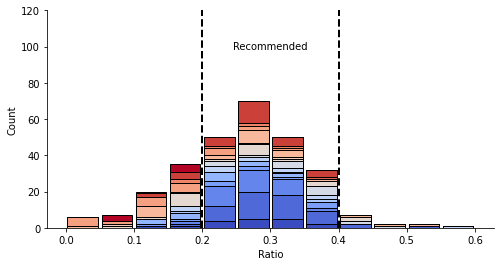

In [48]:
ax = plot_stacked_hist(partial_sleep_stages_df,'rem2nrem',[0,0.6],width=.05)
ax.set_ylabel('Count')
ax.set_ylim([0,120])
ax.set_xlabel('Ratio')
for loc in ['right','top']:
    ax.spines[loc].set_visible(False)
    
ax.axvline(0.2,color='black',linestyle='dashed',linewidth=2)
ax.axvline(0.4,color='black',linestyle='dashed',linewidth=2)
ax.text(0.3,100,"Recommended",ha='center',va='center')
    
#plt.savefig('../reports/figures/fitbit_sleep_rem2nrem-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

#### Combined Plot
Now we subplot each of the "good" sleep metric figures together.

In [49]:
partial_sleep_params_df = pd.DataFrame()
for pt in partial_sleep_metric_df["beiwe"].unique():
    df_pt = partial_sleep_metric_df[partial_sleep_metric_df["beiwe"] == pt]
    ss_pt = partial_sleep_stages_df[partial_sleep_stages_df["beiwe"] == pt]
    df_pt["rem2nrem"] = ss_pt["rem2nrem"]
    n = len(df_pt)
    df_pt["n"] = n
    partial_sleep_params_df = partial_sleep_params_df.append(df_pt)

partial_sleep_params_df.sort_values("n",inplace=True,ascending=False)

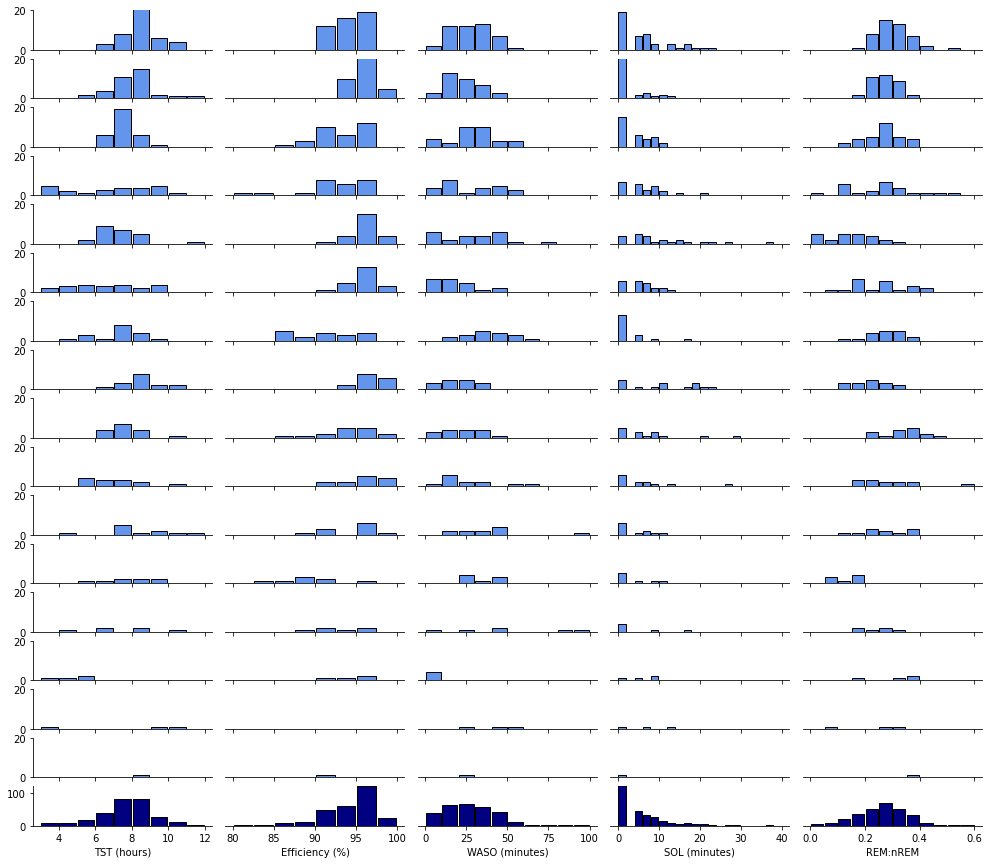

In [50]:
fig, axes = plt.subplots(len(partial_sleep_params_df["beiwe"].unique())+1,5,figsize=(17,15),sharex="col")#,sharey="row")
for i, pt in enumerate(partial_sleep_params_df["beiwe"].unique()):
    # getting sleep metrics per pt
    df_pt = partial_sleep_params_df[partial_sleep_params_df["beiwe"] == pt]
    # plotting each histogram per pt
    for j, metric, xlimits, width in zip(np.arange(5),["hours_asleep","efficiency","waso","sol","rem2nrem"],[[3,12],[80,100],[0,100],[0,40],[0,0.6]],[1,2.5,10,2,0.05]):
        n, bins, _ = axes[i,j].hist(df_pt[metric],bins=np.arange(xlimits[0],xlimits[1]+width,width),rwidth=0.9,color="cornflowerblue",edgecolor='black')
            
        axes[i,j].set_ylim([0,20])
        for loc in ["top","right"]:
            axes[i,j].spines[loc].set_visible(False)
        if j != 0:
            axes[i,j].spines["left"].set_visible(False)
            axes[i,j].set_yticks([])
    
for j, metric, xlimits, width in zip(np.arange(5),["hours_asleep","efficiency","waso","sol","rem2nrem"],[[3,12],[80,100],[0,100],[0,40],[0,0.6]],[1,2.5,10,2,0.05]):
    n, bins, _ = axes[len(partial_sleep_params_df["beiwe"].unique()),j].hist(partial_sleep_params_df[metric],bins=np.arange(xlimits[0],xlimits[1]+width,width),rwidth=0.9,color="navy",edgecolor='black')
    axes[len(partial_sleep_params_df["beiwe"].unique()),j].set_ylim([0,120])
    for loc in ["top","right"]:
        axes[len(partial_sleep_params_df["beiwe"].unique()),j].spines[loc].set_visible(False)
    if j != 0:
        axes[len(partial_sleep_params_df["beiwe"].unique()),j].spines["left"].set_visible(False)
        axes[len(partial_sleep_params_df["beiwe"].unique()),j].set_yticks([])
    
    
for k, label in enumerate(["TST (hours)","Efficiency (%)","WASO (minutes)","SOL (minutes)","REM:nREM"]):
    axes[len(partial_sleep_params_df["beiwe"].unique()),k].set_xlabel(label)
    
plt.subplots_adjust(hspace=0.225,wspace=0.075)
plt.savefig("../reports/figures/fitbit-sleep_metrics-histogram_by_pt-ux_s20.pdf")
plt.show()
plt.close()

## Sleep Minute Data
In addition to nightly summaries, we also have the minute data corresponding to the sleep stages recorded by Fitbit.

In [149]:
sleep_stages = pd.read_csv("../data/processed/fitbit-sleep_stages-ux_s20.csv",index_col="start_date",parse_dates=["start_date","end_date","time"],infer_datetime_format=True)
sleep_stages.head()

,end_date,time,stage,time_at_stage,beiwe,value
start_date,,,,,,
2020-05-14,2020-05-14,2020-05-14 00:27:00,wake,510,hfttkth7,0
2020-05-14,2020-05-14,2020-05-14 00:35:30,light,420,hfttkth7,1
2020-05-14,2020-05-14,2020-05-14 00:42:30,deep,1590,hfttkth7,2
2020-05-14,2020-05-14,2020-05-14 01:09:00,light,1290,hfttkth7,1
2020-05-14,2020-05-14,2020-05-14 01:30:30,rem,840,hfttkth7,3


### Number of Participants
Trying to see if there is a disconnect between the daily and the intra-day stats.

In [52]:
n_pts_ss = len(sleep_stages['beiwe'].unique())
print(f'Number of Participants: {n_pts_ss}')
pts_ss = sleep_stages['beiwe'].unique()

Number of Participants: 53


There **is** a disconnect. Let's look at these participants:

In [53]:
np.sort(pts_daily)

array(['15tejjtw', '1a9udoc5', '1adkek2h', '2xtqkfz1', '37sb8wql',
       '43b1cd5m', '4i7679py', '51opds1x', '5fvmg226', '6rxyg4rp',
       '745vq78e', '7dhu3pn7', '8vpj3b9v', '9jtzsuu8', '9q1adgjk',
       '9xmhtq74', 'awa8uces', 'axk49ssu', 'bayw6h9b', 'drs2jy5f',
       'e73a1pd5', 'e8js2jdf', 'ewvz3zm1', 'eyf8oqwl', 'gqpcflwk',
       'h8aoiyhv', 'hcpu5myv', 'hfttkth7', 'hxj6brwj', 'i31pt4b4',
       'i4w8dx6l', 'idbkjh8u', 'itmylz3g', 'kyj367pi', 'lkkjddam',
       'mm69prai', 'naucsx6v', 'nvtfpaor', 'o6xwrota', 'olaxadz5',
       'oxcpr7e3', 'pgvvwyvh', 'qh34m4r9', 'r11k6uxz', 'rjcs3hyw',
       'rkem5aou', 'rnse61g4', 'rvhdl2la', 'synympvt', 't4jphih6',
       'tlmlq19s', 'tmexej5v', 'vpy1a985', 'vr9j5rry', 'wnprz3dq',
       'xdbdrk6e', 'xlw5ntd5', 'y1tvkx14', 'zdpffrox'], dtype=object)

In [54]:
np.sort(pts_ss)

array(['15tejjtw', '1a9udoc5', '1adkek2h', '2xtqkfz1', '43b1cd5m',
       '4i7679py', '51opds1x', '5fvmg226', '6rxyg4rp', '745vq78e',
       '7dhu3pn7', '8vpj3b9v', '9jtzsuu8', '9q1adgjk', '9xmhtq74',
       'axk49ssu', 'bayw6h9b', 'drs2jy5f', 'e73a1pd5', 'e8js2jdf',
       'eyf8oqwl', 'gqpcflwk', 'h8aoiyhv', 'hcpu5myv', 'hfttkth7',
       'hxj6brwj', 'i31pt4b4', 'i4w8dx6l', 'idbkjh8u', 'itmylz3g',
       'kyj367pi', 'lkkjddam', 'mm69prai', 'nvtfpaor', 'o6xwrota',
       'olaxadz5', 'oxcpr7e3', 'qh34m4r9', 'rjcs3hyw', 'rkem5aou',
       'rnse61g4', 'rvhdl2la', 'synympvt', 't4jphih6', 'tlmlq19s',
       'tmexej5v', 'vpy1a985', 'vr9j5rry', 'wnprz3dq', 'xdbdrk6e',
       'xlw5ntd5', 'y1tvkx14', 'zdpffrox'], dtype=object)

#### Participants with Beacons
From this list of participants, we see how many of them had beacons.

In [55]:
beacon_df = pd.read_csv('../data/processed/beacon-ux_s20.csv',index_col=0)
# GPS
pt_list = []
bb_list = []
# info
info_pt_list = []
info_bb_list = []
for pt, bb in zip(beacon_df['beiwe'].unique(),beacon_df['beacon'].unique()):
    if pt in sleep_stages['beiwe'].unique():
        pt_list.append(pt)
        bb_list.append(bb)

Output

In [56]:
print('Number of Beacon users with Fitbit sleep logged:',len(bb_list))
print('\tFitbit Beacons:', bb_list)
print('\tAll Beacons:', beacon_df['beacon'].unique())

Number of Beacon users with Fitbit sleep logged: 20
	Fitbit Beacons: [1, 5, 10, 15, 16, 17, 19, 21, 24, 25, 28, 29, 30, 32, 34, 36, 38, 40, 44, 46]
	All Beacons: [ 1  5 10 15 16 17 19 21 22 24 25 26 28 29 30 32 34 36 38 40 44 46]


### Histogram of Values
We can look at the values to see the relative abundance of each type of sleep parameter.

### Sleep Times
Unfortunately the data from the minute sleep dataframe is rather useless since it does not supply us with anything more important than the daily summary other than the start and stop times of sleep. Below is a simple figure that shows the periods when participants went to sleep and woke up. 

## Heart Rate
Now we look at the heart rate data

In [57]:
fitbit_intra = pd.read_csv('../data/processed/fitbit-intraday-ux_s20.csv',
            index_col=0, parse_dates=True, infer_datetime_format=True)
fitbit_intra[:10]

,calories,steps,distance,heartrate,beiwe
timestamp,,,,,
2020-05-13 17:39:00,1.69377,NaN,NaN,77.333333,hfttkth7
2020-05-13 17:40:00,1.69377,NaN,NaN,77.600000,hfttkth7
2020-05-13 17:41:00,4.42986,33.0,0.015721,79.000000,hfttkth7
2020-05-13 17:42:00,1.69377,NaN,NaN,83.416667,hfttkth7
2020-05-13 17:43:00,1.43319,NaN,NaN,63.666667,hfttkth7
2020-05-13 17:44:00,NaN,NaN,NaN,64.222222,hfttkth7
2020-05-13 17:45:00,NaN,NaN,NaN,64.142857,hfttkth7
2020-05-13 17:46:00,1.43319,NaN,NaN,64.428571,hfttkth7
2020-05-13 17:47:00,NaN,NaN,NaN,63.800000,hfttkth7


### Number of Participants

In [58]:
n_pts = len(fitbit_intra['beiwe'].unique())
print(f'Number of participants: {n_pts}')
pts_hourly = np.sort(fitbit_intra['beiwe'].unique())

Number of participants: 59


In [59]:
daily_but_no_hourly = daily_fitbit[daily_fitbit['beiwe'] == '5fvmg226']
daily_but_no_hourly

,calories,bmr,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,bmi,fat,weight,food_calories_logged,water_logged,beiwe,activities_minutes,activities_percentage
timestamp,,,,,,,,,,,,,,,,,
2020-05-01,2058.0,1207.0,11499,4.774256,557,399,0,0,1143.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,956,66.388889
2020-05-02,1680.0,1207.0,4683,1.953970,715,228,0,0,609.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,943,65.486111
2020-05-03,2010.0,1207.0,8802,3.645591,492,368,17,1,1081.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,878,60.972222
2020-05-04,1484.0,1207.0,1999,0.811237,821,153,0,0,362.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,974,67.638889
2020-05-05,2058.0,1207.0,11615,4.824947,461,408,0,0,1151.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,869,60.347222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,2328.0,1202.0,15810,6.592487,478,492,18,1,1495.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,989,68.680556
2020-09-28,1431.0,1202.0,1946,0.811958,798,119,0,0,294.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,917,63.680556
2020-09-29,1524.0,1202.0,3410,1.422990,969,144,10,0,409.0,18.037397,0.0,105.0,0.0,0.0,5fvmg226,1123,77.986111
